In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
from PIL import Image
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

In [2]:
#将类别标签变为独热编码
def onehot_code(lables,C):
    C = tf.constant(C,name="C")                                          #创建一个tf.constant，赋值为C，名字叫C
    one_hot_matrix = tf.one_hot(indices=lables , depth=C , axis=0)  #使用tf.one_hot，将分类类别变为独热编码
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)       #运行session
    sess.close()                             #关闭session
    return one_hot

In [3]:
def weight_initialize():
    #初始化权重参数
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    weights = {'W1':W1,'W2':W2}
    return weights

In [4]:
#创建用于tf输入变量的占位符
#输入参数分别为图片高度，宽度，通道数和类别数（这里就是0没有仙人掌，1有仙人掌）
def XY_placeholder(n_h0,n_w0,n_c0,n_y):
    X = tf.placeholder(tf.float32, [None,n_h0,n_w0,n_c0])
    Y = tf.placeholder(tf.float32, [None,n_y])
    return X, Y

In [5]:
#实现卷积网络的前向传播
def conv_forward(X0,parameters0):
    W1=parameters0['W1']
    W2=parameters0['W2']
    #第一层
    Z1=tf.nn.conv2d(X0,W1,strides=[1,1,1,1],padding='SAME')                #卷积函数 输出:(图片数，高度，宽度，每个通道包含卷积核数量)
    A1=tf.nn.relu(Z1)
    P1=tf.nn.max_pool(A1,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME') #池化函数 输出:(图片数，高度，宽度，通道数)
    #第二层
    Z2=tf.nn.conv2d(P1,W2,strides=[1,2,2,1],padding='SAME')
    A2=tf.nn.relu(Z2)
    P2=tf.nn.max_pool(A2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    #展平和输出全连接层
    P=tf.contrib.layers.flatten(P2)
    Z3=tf.contrib.layers.fully_connected(P,2,activation_fn=None)           #全联接层输出：(图片数，分类数)
    
    return Z3

In [6]:
def cost_computation(Z3,Y):
    #这里选择交叉熵来计算用来优化的损失函数
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    #交叉熵函数先对logits中每一行进行softmax，得y'，再按每一行和实际标签y做交叉熵y*log(y')的和
    return cost

In [7]:
def split_deal(X, Y, part_size = 500, seed = 0):
    m = X.shape[0]                  # 训练集的样本数量
    parts = []
    np.random.seed(seed)
    # 第一步打乱数据和标签
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]
    # 第二步：分离
    num_complete_parts = math.floor(m/part_size) 
    for k in range(0, num_complete_parts):
        part_X = shuffled_X[k * part_size : k * part_size + part_size,:,:,:]
        part_Y = shuffled_Y[k * part_size : k * part_size + part_size,:]
        part = (part_X, part_Y)
        parts.append(part)
    if m % part_size != 0:
        part_X = shuffled_X[num_complete_parts *part_size : m,:,:,:]
        part_Y = shuffled_Y[num_complete_parts * part_size : m,:]
        part = (part_X, part_Y)
        parts.append(part)
    return parts

In [8]:
#预测函数的实现
def predict(X,parameters):
    W1=parameters['W1']
    W2=parameters['W2']
    
    Z1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    A1=tf.nn.relu(Z1)
    P1=tf.nn.max_pool(A1,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    Z2=tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    A2=tf.nn.relu(Z2)
    P2=tf.nn.max_pool(A2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    Z3=tf.contrib.layers.flatten(P2)
    Z3=tf.contrib.layers.fully_connected(Z3,2,activation_fn=None)
    Z4=tf.argmax(Z3,axis=1)
        
    return Z4

In [9]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.010,epochs=100,minibatch_size=500,print_cost=True,isplot=True):
    ops.reset_default_graph()    #能够重新运行模型而不覆盖
    tf.set_random_seed(1)
    seed=3
    m,h,w,c=X_train.shape
    n_y=Y_train.shape[1]
    costs=[]
    
    X,Y=XY_placeholder(h,w,c,n_y)
    parameters=weight_initialize()
    Z=conv_forward(X,parameters)
    J=cost_computation(Z,Y)
    
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(J)
    
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(epochs):
            minibatch_J=0
            num_minibatches=int(m/minibatch_size)       #获取数据块的数量
            seed=seed+1
            minibatches=split_deal(X_train,Y_train,minibatch_size,seed)
            
            #对每个数据块进行处理
            for minibatch in minibatches:
                minibatch_X,minibatch_Y=minibatch      #选择一个数据块
                _,temp_J=sess.run([optimizer,J],feed_dict={X:minibatch_X,Y:minibatch_Y})   #最小化这个数据块的成本
                
                minibatch_J+=temp_J/num_minibatches    #累加数块的成本值
                
            if print_cost:
                if epoch % 5==0:
                    print('当前是第'+str(epoch)+'代，成本是'+str(minibatch_J))
                
            if epoch % 1==0:
                costs.append(minibatch_J)
                
        if isplot:
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations')
            plt.title('Learning rate='+str(learning_rate))
            plt.show()
                
            #开始预测数据
            ##计算当前的预测情况
            predict_op=tf.arg_max(Z,1)
            current_prediction=tf.equal(predict_op,tf.arg_max(Y,1))
                
            ##计算准确度
            accuracy=tf.reduce_mean(tf.cast(current_prediction,'float'))
            print('current prediction accuracy='+str(accuracy))
                
            train_accuracy=accuracy.eval({X:X_train,Y:Y_train})
            test_accuracy=accuracy.eval({X:X_test,Y:Y_test})
                
            print('训练集准确度'+str(train_accuracy))                  #train_accuracy - 实数，训练集的准确度
            print('测试集准确度'+str(test_accuracy))                   #test_accuracy - 实数，测试集的准确度
                                                                    
            tf.train.Saver().save(sess, "D:/kaggle/aerial-cactus-identification/model.ckpt")      #保存已经训练好的模型
            
    return train_accuracy,test_accuracy,parameters                #parameters - 学习后的参数

In [3]:
#上面为函数，下面开始为主程序
train_data=pd.read_csv('train.csv')
submission_data=pd.read_csv('sample_submission.csv')

In [ ]:
#读取训练集图片并转化为数组
'''
for file in os.walk('train'):
    train_names=file[2]
    
X_trainall=[]
for pnum in range(len(train_names)):
    im=Image.open('train/'+train_names[pnum])
    im_array=np.array(im)
    X_trainall=list(X_trainall)
    X_trainall.append(im_array)
    X_trainall=np.array(X_trainall)
    s=X_trainall.shape
    print(s)
'''

In [ ]:
#读取测试集图片并转化为数组
'''
for file2 in os.walk('test'):
    test_names=file2[2]
X_test=[]
for pnum2 in range(len(test_names)):
    im2=Image.open('test/'+test_names[pnum2])
    im_array2=np.array(im2)
    X_test=list(X_test)
    X_test.append(im_array2)
    X_test=np.array(X_test)
    s2=X_test.shape
    print(s2)
'''

In [7]:
#type(train_data)
#np.save(file='train_picture',arr=X_trainall)
#np.save(file='test_picture',arr=X_test)
'''
all_train=np.load(file='train_picture.npy')
a1=all_train[0:8750,:,:,:]
a2=all_train[8750:,:,:,:]
np.save(file='train_picture1',arr=a1)
np.save(file='train_picture2',arr=a2)
'''
X_realtest=np.load(file='test_picture.npy')
all_train1=list(np.load(file='train_picture1.npy'))
all_train2=list(np.load(file='train_picture2.npy'))
all_train1.extend(all_train2)
all_train=np.array(all_train1)
print(all_train.shape)
#temp=all_train
#train,test = train_test_split(temp,test_size=0.3)
all_train_labels=train_data.iloc[:,1].values

(17500, 32, 32, 3)


当前是第0代，成本是7.511755235493182
当前是第5代，成本是0.5355621712903182
当前是第10代，成本是0.25186799031992757
当前是第15代，成本是0.2027734766403834
当前是第20代，成本是0.1657118980462353
当前是第25代，成本是0.13883120846003297
当前是第30代，成本是0.13672482160230476
当前是第35代，成本是0.1520391485343377
当前是第40代，成本是0.1293378509581089
当前是第45代，成本是0.12692845178147155
当前是第50代，成本是0.1252489487330119
当前是第55代，成本是0.11848817424227794
当前是第60代，成本是0.12555094466855127
当前是第65代，成本是0.12258639900634685
当前是第70代，成本是0.12792984955012798
当前是第75代，成本是0.11123527803768715
当前是第80代，成本是0.11824986866364874
当前是第85代，成本是0.0985774804527561
当前是第90代，成本是0.10088607544700305
当前是第95代，成本是0.09606055015077195


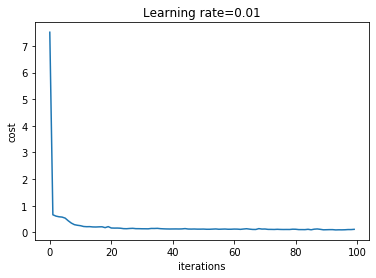

current prediction accuracy=Tensor("Mean_1:0", shape=(), dtype=float32)
训练集准确度0.94865304
测试集准确度0.9487619


In [28]:
#从训练数据中分割处用于训练模型和初步测试模型的数据集
np.random.seed(1)
np.random.shuffle(all_train)
np.random.seed(1)
np.random.shuffle(all_train_labels)
s=int(17500*0.7)
s1=int(17500*0.3)
X_train=all_train[:s,:,:,:]        #0.7的训练数据集
X_test=all_train[s:,:,:,:]         #0.3的测试数据集
Y1=all_train_labels[:s]            #0.7的训练数据集标签
Y_train=onehot_code(Y1,C=2)         #进行独热编码
Y_train=Y_train.T
Y2=all_train_labels[s:]            #0.3的测试数据集标签
Y_test=onehot_code(Y2,C=2)         #独热编码
Y_test=Y_test.T
train_ac,test_ac,parameters = model(X_train, Y_train, X_test, Y_test,learning_rate=0.010,epochs=100)

In [27]:
saver = tf.train.import_meta_graph('D:/kaggle/aerial-cactus-identification/model.ckpt.meta')
with tf.Session() as sess_test:
    saver.restore(sess_test, tf.train.latest_checkpoint(''))
    graph = tf.get_default_graph()
    w1 = graph.get_tensor_by_name("W1:0")
    w2 = graph.get_tensor_by_name("W2:0")
    parameters={'W1':w1,'W2':w2}
    xp=tf.placeholder(tf.float32,[None,32,32,3])
    temp=predict(xp,parameters)
    sess_test.run(tf.global_variables_initializer())
    p=sess_test.run(temp,feed_dict={xp:X_realtest})
    prediction=p
    print(prediction)

INFO:tensorflow:Restoring parameters from D:/kaggle/aerial-cactus-identification/model.ckpt
[0 0 0 ... 0 0 0]


In [14]:
type(X_realtest)

numpy.ndarray

In [15]:
results=pd.DataFrame(prediction)
results.to_csv('results.csv')
df=pd.read_csv('results.csv', header=0)
df.columns=['ImageId','Label']
df.to_csv('results.csv', index=False)